In [2]:
### package
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
### read data function
def read_one_year(year, c_idx_list, timestep, datatype, 
                  height=157, width=103, keep_missing_hour=True):  
    start_time = datetime(year, 1, 1, 0)
    end_time = datetime(year + 1, 1, 1, 0)
    delta = timedelta(hours=timestep)

    data_tensor = []  
    mask_tensor = []
    current_time = start_time
    while current_time < end_time:
        timestamp = current_time.strftime('%Y%m%d%H')
        path = construct_file_path(year, timestamp, datatype)   # 建立檔案完整路徑
        grid_data = read_data_from_file(path, c_idx_list)   # 讀取檔案

        if grid_data is not None:
            valid_values = grid_data[torch.isfinite(grid_data)]    # 回傳既不是 NaN 或 ±Inf 的值
            if valid_values.numel() > 0 and torch.all(valid_values == valid_values[0]):   # 如果tensor的數值都一樣，視為異常數據
                data_tensor.append(torch.full((len(c_idx_list), height, width), float('nan')))
                mask_tensor.append(0.0)
                print(f"All valid values are the same in file: {path}. Replacing with NaN tensor.")
            else:
                data_tensor.append(grid_data)
                mask_tensor.append(1.0)
        else:
            if keep_missing_hour:
                data_tensor.append(torch.full((len(c_idx_list), height, width), float('nan')))
                mask_tensor.append(0.0)

        current_time += delta

    return torch.stack(data_tensor), torch.tensor(mask_tensor)    # [total hours, C, H, W]


def construct_file_path(year, timestamp, mode):
    if mode == "surfgrid": 
        return f"C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_{year}(hour)/surfgrid_RCEC_{timestamp}.pt"
    elif mode == "obs":
        return f"C:/Users/kevin/Documents/新 科技部計畫/PT_observation_{year}(hour)/observation_{timestamp}.pt"
    else:
        raise ValueError("Invalid mode! Must be 'surfgrid' or 'obs'.")


def read_data_from_file(path, c_idx):
    if os.path.exists(path):
        return torch.load(path, weights_only=True)[c_idx, ...]  # [C_selected, H, W]
    else:
        print(f"⚠️ Missing file: {path}")
        return None


def read_data(year_list: list,c_idx_list: list, timestep: int, 
              datatype: str, keep_missing_hour=True):
    """
    載入多個年份的資料，將其串接成一個大tensor，支援多通道輸入。
    return：data_tensor: [8760, C, H, W], mask_tensor: [8760]
    """
    all_data_tensors = []
    all_mask_tensors = []   # 遺失或是資料不正確為0

    for year in year_list:
        data_tensor, mask_tensor = read_one_year(
            int(year), c_idx_list, int(timestep), datatype, keep_missing_hour=keep_missing_hour
        )
        all_data_tensors.append(data_tensor)
        all_mask_tensors.append(mask_tensor)

    return torch.cat(all_data_tensors), torch.cat(all_mask_tensors)

In [4]:
### loading data tensor
data_tensor, mask_tensor = read_data(
    year_list=[2024],
    c_idx_list=[3, 5, 6, 7, 8],
    timestep=1,
    datatype='surfgrid'
)  # data_tensor: [T_total, C, H, W], mask_tensor: [T_total]

⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032400.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032401.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032402.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032403.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032404.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032405.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032406.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032407.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid_RCEC_2024032408.pt
⚠️ Missing file: C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2024(hour)/surfgrid

In [5]:
### convert wind to u,v 
def convert_wind_to_uv(data_tensor: torch.Tensor, speed_idx: int, dir_idx: int):
    speed = data_tensor[:, speed_idx]
    direction = data_tensor[:, dir_idx]

    if torch.any(direction < 0):
        print("Skip: already converted to u/v.")
        return data_tensor

    theta_rad = direction * torch.pi / 180.0
    u = -speed * torch.sin(theta_rad)
    v = -speed * torch.cos(theta_rad)

    data_tensor[:, speed_idx] = u
    data_tensor[:, dir_idx] = v

    print("Wind converted to u/v.")
    return data_tensor

data_tensor = convert_wind_to_uv(data_tensor, speed_idx=1, dir_idx=2)

Wind converted to u/v.


In [6]:
### class dataset
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, data_tensor: torch.Tensor, 
                 mask_tensor: torch.Tensor, 
                 T_in: int, T: int, 
                 stride: int = 1,
                 add_lonlat: bool = False):
        """
        建立基於 sliding window 的時間序列 Dataset，並選擇性合併經緯度資訊。
        - stride: 時間步長 (每幾個時間點取一筆樣本)
        """
        self.data = data_tensor
        self.mask = mask_tensor
        self.T_in = T_in
        self.T = T
        self.stride = stride
        self.window_size = T_in + T
        self.add_lonlat = add_lonlat

        if add_lonlat:
            fixed_path = "C:/Users/kevin/Documents/新 科技部計畫/PT_grid_data_2023(hour)/surfgrid_RCEC_2023010100.pt"
            self.grid_lonlat = self._load_and_process_lonlat(fixed_path)
        else:
            self.grid_lonlat = None

        self.valid_indices = self._compute_valid_indices()

    def _load_and_process_lonlat(self, path: str) -> torch.Tensor:
        latlon_tensor = torch.load(path, weights_only=True)  # [C, H, W]
        lat = latlon_tensor[0]
        lon = latlon_tensor[1]

        def normalize(tensor):
            min_val = tensor.min()
            max_val = tensor.max()
            return 2 * (tensor - min_val) / (max_val - min_val) - 1

        lat = normalize(lat)
        lon = normalize(lon)
        return torch.stack([lon, lat], dim=0)  # [2, H, W]

    def _compute_valid_indices(self):
        valid_indices = []
        total_steps = self.data.shape[0]
        for i in range(0, total_steps - self.window_size + 1, self.stride):  
            window_mask = self.mask[i: i + self.window_size]
            if window_mask.all():
                valid_indices.append(i)
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        end_idx = start_idx + self.window_size
        window = self.data[start_idx:end_idx]
        
        X = window[:self.T_in, :1]     # PM25
        y = window[self.T_in:]

        T_in, C_in = X.shape[0], X.shape[1]
        X = X.reshape(T_in * C_in, *X.shape[2:])

        T_out, C_out = y.shape[0], y.shape[1]
        y = y.reshape(T_out * C_out, *y.shape[2:])

        if self.add_lonlat and self.grid_lonlat is not None:
            X = torch.cat([X, self.grid_lonlat], dim=0)

        return X, y

In [7]:
### build dataset/dataloader
T_in = 1
T = 24
stride = 1

dataset = TimeSeriesWindowDataset(data_tensor, mask_tensor, T_in, T, stride)

n_sample = len(dataset)
print("資料數量: ", n_sample)

batch_size = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

資料數量:  2112


In [8]:
# check dataloader
def check_dataloader_nan_and_range(dataloader, name=""):
    print(f"\n📦 檢查 DataLoader：{name}")
    for i, (batch_X, batch_y) in enumerate(dataloader):
        nan_X = torch.isnan(batch_X).any().item()
        nan_y = torch.isnan(batch_y).any().item()

        print(f"🔁 Batch {i+1}:")
        print(f" - X shape: {batch_X.shape}, 含 NaN: {nan_X}")
        print(f" - y shape: {batch_y.shape}, 含 NaN: {nan_y}")

        if not nan_X:
            # 假設 batch_X 形狀為  
            C = batch_X.shape[1]
            for c in range(C):
                x_c = batch_X[:, c, :, :].flatten()
                min_val = x_c.min().item()
                max_val = x_c.max().item()
                median_val = x_c.median().item()
                print(f"   - 通道 {c}: min={min_val:.2f}, median={median_val:.2f}, max={max_val:.2f}")
        else:
            print(" - X 數值範圍: (含 NaN，略過 per-channel 統計)")

# ✅ 執行檢查
check_dataloader_nan_and_range(data_loader, "Test")


📦 檢查 DataLoader：Test
🔁 Batch 1:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=0.42, median=29.05, max=61.55
🔁 Batch 2:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=0.48, median=27.58, max=64.88
🔁 Batch 3:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=0.41, median=26.58, max=60.07
🔁 Batch 4:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=0.40, median=25.62, max=56.12
🔁 Batch 5:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=0.38, median=24.23, max=50.39
🔁 Batch 6:
 - X shape: torch.Size([1, 1, 157, 103]), 含 NaN: False
 - y shape: torch.Size([1, 120, 157, 103]), 含 NaN: False
   - 通道 0: min=

In [ ]:
### load model
from afnonet import AFNONet
from argparse import Namespace

params = Namespace(
    patch_size=4,
    N_in_channels=7,
    N_out_channels=1,
    num_blocks=4
)

model = AFNONet(img_size=(160, 128), params=params, embed_dim=112, depth=3)
model.cuda()

AFNONet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(7, 112, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-2): 3 x Block(
      (norm1): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
      (filter): AFNO2D()
      (drop_path): Identity()
      (norm2): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=112, out_features=448, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=448, out_features=112, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=112, out_features=16, bias=False)
)

In [11]:
### load model param
device = 'cuda'
checkpoint = torch.load('best_AFNO_1to1_cond.pth', map_location=device, weights_only=True) 
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
### model summary
from torchinfo import summary

print(summary(model, input_size=(2, 7, 157, 103)))

Layer (type:depth-idx)                   Output Shape              Param #
AFNONet                                  [2, 1, 157, 103]          143,584
├─PatchEmbed: 1-1                        [2, 1280, 112]            --
│    └─Conv2d: 2-1                       [2, 112, 40, 32]          12,656
├─Dropout: 1-2                           [2, 1280, 112]            --
├─ModuleList: 1-3                        --                        --
│    └─Block: 2-2                        [2, 40, 32, 112]          --
│    │    └─LayerNorm: 3-1               [2, 40, 32, 112]          224
│    │    └─AFNO2D: 3-2                  [2, 40, 32, 112]          12,992
│    │    └─LayerNorm: 3-3               [2, 40, 32, 112]          224
│    │    └─Mlp: 3-4                     [2, 40, 32, 112]          100,912
│    │    └─Identity: 3-5                [2, 40, 32, 112]          --
│    └─Block: 2-3                        [2, 40, 32, 112]          --
│    │    └─LayerNorm: 3-6               [2, 40, 32, 112]        

In [14]:
# load lonlat function
def load_and_process_lonlat(path: str) -> torch.Tensor:
    latlon_tensor = torch.load(path, weights_only=True, map_location=device)  # [2, H, W]
    lat = latlon_tensor[0]
    lon = latlon_tensor[1]

    def normalize(tensor):
        min_val = tensor.min()
        max_val = tensor.max()
        return 2 * (tensor - min_val) / (max_val - min_val) - 1

    lat = normalize(lat)
    lon = normalize(lon)

    # 合併並擴展為 [B, 2, H, W]
    latlon = torch.stack([lat, lon], dim=0)              # [2, H, W]

    return latlon

# load lonlat
lonlat = load_and_process_lonlat("../PT_grid_data_2023(hour)/surfgrid_RCEC_2023010100.pt") # [2, H, W]

In [15]:
### autoregressive inference
model.eval()

mae_sum = [0.0 for _ in range(T)]
rmse_sum = [0.0 for _ in range(T)]

mae_high_sum = [0.0 for _ in range(T)]
rmse_high_sum = [0.0 for _ in range(T)]

count = 0

# 自回歸推理 + 即時計算誤差（每一步移除 GPU 資源）
for x, y in tqdm(data_loader, desc='Evaluating'):
    x = x.to(device)            # [B, C, H, W]

    x_current = x    # [B, 1, H, W]

    for t in range(T):
        init = t*5
        y_current = y[:, init:init+5]

        y_pm25 = y_current[:, :1]
        cond = y_current[:, 1:].to(device)

        x_cond = torch.cat([x_current, cond], dim=1)
        
        lonlat_batch = lonlat.unsqueeze(0).repeat(x.size(0), 1, 1, 1)  # [B, 2, H, W]
        x_cond = torch.cat([x_cond, lonlat_batch], dim=1)   # [B, 8, H, W]

        res = (model(x_cond)).detach().cpu()       # [B, 1, H, W]
        x_current = x_current.detach().cpu()
        pred = x_current + res

        abs_error = torch.abs(pred - y_pm25)
        squared_error = (pred - y_pm25) ** 2

        mae_sum[t] += abs_error.mean()
        rmse_sum[t] += torch.sqrt(squared_error.mean())

        # ✅ 高濃度區域的誤差計算
        mask = (y_pm25 > 35)  # [B, 1, H, W]，布林遮罩
        if mask.sum() > 0:
            mae_high = abs_error[mask].mean().item()
            rmse_high = torch.sqrt(squared_error[mask].mean()).item()
            mae_high_sum[t] += mae_high
            rmse_high_sum[t] += rmse_high

        pred = pred.to(device)
        x_current = pred

    count += 1


Evaluating: 100%|██████████| 2112/2112 [04:10<00:00,  8.43it/s]


In [16]:
### mean hourly errors

# 平均化
mae_avg = [val / count for val in mae_sum]
rmse_avg = [val / count for val in rmse_sum]
mae_high_avg = [val / count for val in mae_high_sum]
rmse_high_avg = [val / count for val in rmse_high_sum]

# 顯示結果
for t in range(T):
    print(f"Step {t+1}: MAE = {mae_avg[t]:.4f}, RMSE = {rmse_avg[t]:.4f}")

for t in range(T):
    print(f"Step {t+1}: MAE (high) = {mae_high_avg[t]:.4f}, RMSE (high) = {rmse_high_avg[t]:.4f}")

Step 1: MAE = 0.9115, RMSE = 1.4679
Step 2: MAE = 1.5387, RMSE = 2.3845
Step 3: MAE = 2.1025, RMSE = 3.1915
Step 4: MAE = 2.6200, RMSE = 3.9066
Step 5: MAE = 3.0900, RMSE = 4.5264
Step 6: MAE = 3.5213, RMSE = 5.0731
Step 7: MAE = 3.9208, RMSE = 5.5649
Step 8: MAE = 4.2917, RMSE = 6.0140
Step 9: MAE = 4.6395, RMSE = 6.4325
Step 10: MAE = 4.9675, RMSE = 6.8247
Step 11: MAE = 5.2773, RMSE = 7.1934
Step 12: MAE = 5.5680, RMSE = 7.5385
Step 13: MAE = 5.8394, RMSE = 7.8584
Step 14: MAE = 6.0911, RMSE = 8.1535
Step 15: MAE = 6.3230, RMSE = 8.4232
Step 16: MAE = 6.5367, RMSE = 8.6700
Step 17: MAE = 6.7366, RMSE = 8.8990
Step 18: MAE = 6.9252, RMSE = 9.1139
Step 19: MAE = 7.1031, RMSE = 9.3160
Step 20: MAE = 7.2699, RMSE = 9.5048
Step 21: MAE = 7.4252, RMSE = 9.6793
Step 22: MAE = 7.5695, RMSE = 9.8400
Step 23: MAE = 7.7028, RMSE = 9.9877
Step 24: MAE = 7.8271, RMSE = 10.1248
Step 1: MAE (high) = 3.7800, RMSE (high) = 4.8293
Step 2: MAE (high) = 5.6994, RMSE (high) = 7.0135
Step 3: MAE (high) =

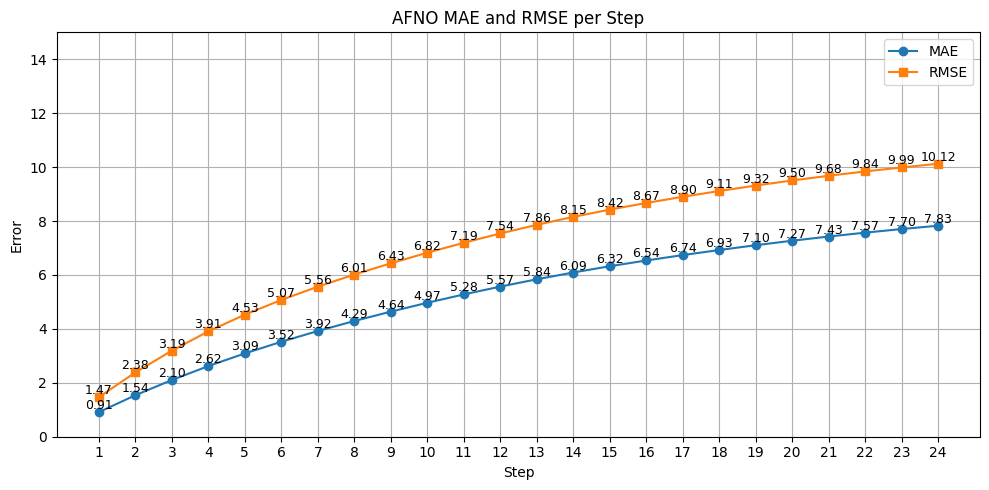

In [23]:
### plot rmse, mae

steps = list(range(1, T + 1))  # 時間步，從 1 到 T

plt.figure(figsize=(10, 5))
plt.plot(steps, mae_avg, marker='o', label='MAE')
plt.plot(steps, rmse_avg, marker='s', label='RMSE')

# 顯示數值標籤（MAE）
for i, val in enumerate(mae_avg):
    plt.text(steps[i], val, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 顯示數值標籤（RMSE）
for i, val in enumerate(rmse_avg):
    plt.text(steps[i], val, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(steps)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('AFNO MAE and RMSE per Step')
plt.grid(True)
plt.legend()
plt.ylim((0, 15))
plt.tight_layout()
plt.show()

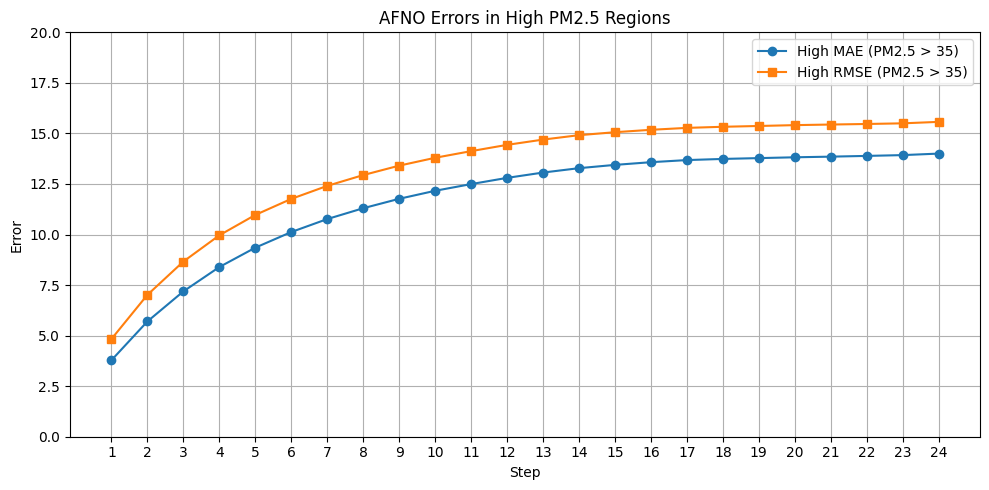

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(steps, mae_high_avg, marker='o', label='High MAE (PM2.5 > 35)')
plt.plot(steps, rmse_high_avg, marker='s', label='High RMSE (PM2.5 > 35)')
plt.xticks(steps)
plt.xlabel('Step')
plt.ylabel('Error')
plt.ylim((0, 20))
plt.title('AFNO Errors in High PM2.5 Regions')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
### visualize the prediction
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ---------- 取得樣本 ----------
# 設定你想要的 batch 編號和 sample 編號
target_batch_index = 15   # 取第 n 個 batch（從 0 開始）
target_sample_index = 0  # 取 batch 中第 m 筆樣本

# 迭代 dataloader，找到目標 batch
for batch_idx, (x_batch, y_batch) in enumerate(data_loader):
    if batch_idx == target_batch_index:
        x_sample = x_batch[target_sample_index].unsqueeze(0).to(device)  # [1, T, H, W]
        y_sample = y_batch[target_sample_index].unsqueeze(0).cpu()       # [1, T, H, W]
        break

# ---------- 自回歸推論 ----------
model.eval()
pred_list = []
y_list = []
with torch.no_grad():  # [1, 6, H, W]
    x_current = x_sample
    for t in range(T):
        init = t*5
        y_current = y_sample[:, init:init+5]

        y_pm25 = y_current[:, :1]
        cond = y_current[:, 1:].to(device)

        x_cond = torch.cat([x_current, cond], dim=1)

        lonlat_batch = lonlat.unsqueeze(0).repeat(x_sample.size(0), 1, 1, 1)  # [B, 2, H, W]
        x_cond = torch.cat([x_cond, lonlat_batch], dim=1)
        
        res = (model(x_cond)).detach().cpu()
        x_current = x_current.detach().cpu()
        pred = x_current + res

        pred_list.append(pred[0, 0])    # [H, W]
        y_list.append(y_pm25[0, 0])

        pred = pred.to(device)       
        x_current = pred

pred_tensor = torch.stack(pred_list, dim=0)         # [T, H, W]
y_sample = torch.stack(y_list, dim=0) 
error_tensor = pred_tensor - y_sample               # [T, H, W]

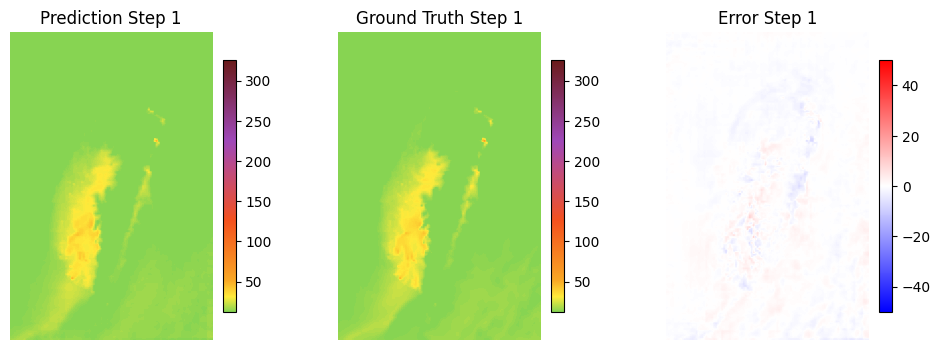

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

# ---------- 色階準備 ----------
pm25_values = [12.4, 30.4, 50.4, 125.4, 225.4, 325.4]
colors = ["#87D452", "#FFEB3B", "#F9A825", "#F4511E", "#9F48B9", "#6A1B1A"]
normalized_positions = [(v - pm25_values[0]) / (pm25_values[-1] - pm25_values[0]) for v in pm25_values]
default_cmap = LinearSegmentedColormap.from_list("pm25_custom", list(zip(normalized_positions, colors)))
default_norm = plt.Normalize(vmin=pm25_values[0], vmax=pm25_values[-1])

# ---------- 初始化圖 ----------
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
im_pred = axes[0].imshow(pred_tensor[0], cmap=default_cmap, norm=default_norm)
axes[0].set_title('Prediction')
axes[0].axis('off')

im_true = axes[1].imshow(y_sample[0], cmap=default_cmap, norm=default_norm)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

im_err = axes[2].imshow(error_tensor[0], cmap='bwr', vmin=-50, vmax=50)
axes[2].set_title('Error')
axes[2].axis('off')

plt.colorbar(im_pred, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im_true, ax=axes[1], fraction=0.046, pad=0.04)
plt.colorbar(im_err, ax=axes[2], fraction=0.046, pad=0.04)

# ---------- 更新函數 ----------
def update(t):
    im_pred.set_data(pred_tensor[t])
    axes[0].set_title(f'Prediction Step {t+1}')

    im_true.set_data(y_sample[t])
    axes[1].set_title(f'Ground Truth Step {t+1}')

    im_err.set_data(error_tensor[t])
    axes[2].set_title(f'Error Step {t+1}')

    return im_pred, im_true, im_err

# ---------- 動畫製作 ----------
ani = animation.FuncAnimation(fig, update, frames=T, interval=1000, blit=False)
ani.save('pm25_high_animation.gif', writer='pillow', fps=3)

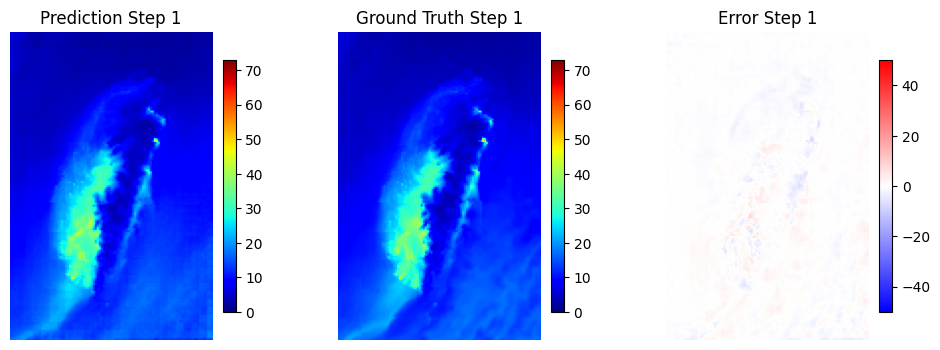

In [22]:
### visualize
# ---------- 色階統一 ----------
vmin = min(pred_tensor.min(), y_sample.min()).item()
vmax = max(pred_tensor.max(), y_sample.max()).item()
err_abs_max = torch.max(torch.abs(error_tensor)).item()

# ---------- 畫圖 ----------
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 初始化三張圖
im_pred = axes[0].imshow(pred_tensor[0], cmap='jet', vmin=0, vmax=vmax)
axes[0].set_title('Prediction')
axes[0].axis('off')

im_true = axes[1].imshow(y_sample[0], cmap='jet', vmin=0, vmax=vmax)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

im_err = axes[2].imshow(error_tensor[0], cmap='bwr', vmin=-50, vmax=50)
axes[2].set_title('Error')
axes[2].axis('off')

# 加入 colorbar
plt.colorbar(im_pred, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im_true, ax=axes[1], fraction=0.046, pad=0.04)
plt.colorbar(im_err, ax=axes[2], fraction=0.046, pad=0.04)

# 更新函數
def update(t):
    im_pred.set_data(pred_tensor[t])
    axes[0].set_title(f'Prediction Step {t+1}')
    
    im_true.set_data(y_sample[t])
    axes[1].set_title(f'Ground Truth Step {t+1}')
    
    im_err.set_data(error_tensor[t])
    axes[2].set_title(f'Error Step {t+1}')
    
    return im_pred, im_true, im_err

# 建立動畫
ani = animation.FuncAnimation(fig, update, frames=T, interval=1000, blit=False)
ani.save('pm25_animation.gif', writer='pillow', fps=3)
